In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
import os
import cv2
from tqdm.notebook import tqdm

# Initialize lists for images and labels
X = []
y = []

# Load images with tumor ('yes' folder)
os.chdir(r"/content/drive/MyDrive/Data/MRIData/yes")
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(1)  # Label for images with tumors

# Load images without tumor ('no' folder)
os.chdir(r"/content/drive/MyDrive/Data/MRIData/no")
for i in tqdm(os.listdir()):
    img = cv2.imread(i)
    if img is not None:
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(0)  # Label for images without tumors


  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
X = np.array(X)
y = np.array(y)

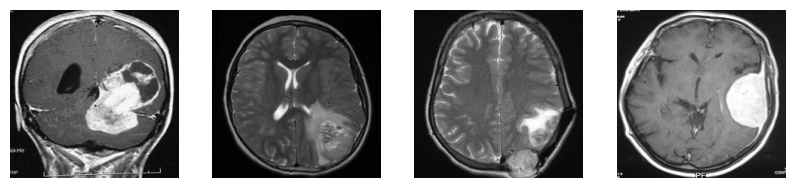

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4,i+1)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
# Load the EfficientNetB5 model
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
# Freeze the base model layers
base_model.trainable = False

In [ ]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Additional Dropout layer
output = Dense(2, activation='softmax')(x)

In [ ]:
# Create the model
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [ ]:

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
6/6 [==============================] - 28s 2s/step - loss: 0.6107 - accuracy: 0.6982 - val_loss: 0.4886 - val_accuracy: 0.7738 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 9s 2s/step - loss: 0.4400 - accuracy: 0.8166 - val_loss: 0.4161 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 9s 2s/step - loss: 0.3124 - accuracy: 0.8876 - val_loss: 0.5122 - val_accuracy: 0.7976 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - 9s 2s/step - loss: 0.3609 - accuracy: 0.8166 - val_loss: 0.3874 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 10s 2s/step - loss: 0.3409 - accuracy: 0.8698 - val_loss: 0.3729 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 6/30
6/6 [==============================] - 9s 2s/step - loss: 0.2501 - accuracy: 0.9112 - val_loss: 0.3639 - val_accuracy: 0.8929 - lr: 0.0010
Epoch 7/30
6/6 [==============================] - 9s 2s/step - loss: 0.2539 - accuracy: 0.8994 - v

In [ ]:

# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

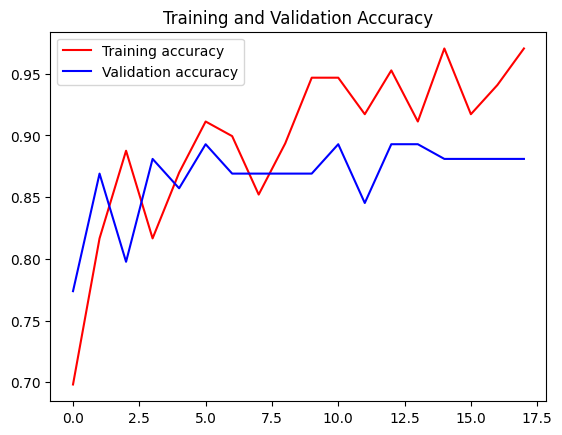

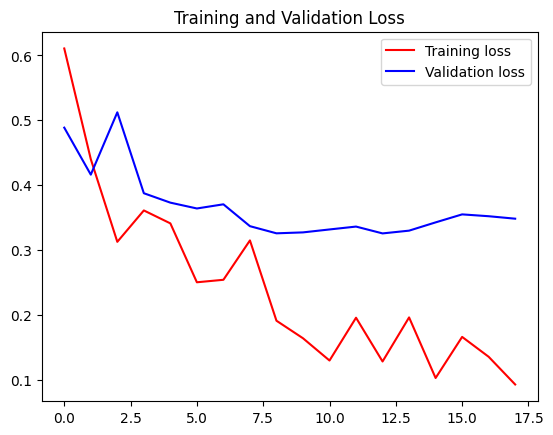

In [ ]:

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.show()

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.applications import vgg16

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = vgg16.preprocess_input(img_array)  # Preprocess input

    prediction = model.predict(img_array)
    print("Raw prediction probabilities:", prediction)

    # Threshold at 0.5 for binary classification
    probability_no_tumor = prediction[0][1]
    if probability_no_tumor > 0.5:
        return "Tumor detected"
    else:
        return "No tumor detected"

# Test prediction
img_path = r'/content/drive/MyDrive/Data/MRIData/no/10 no.jpg'
result = predict_image(img_path, model)
print(result)


1/1 [==============================] - 0s 135ms/step
Raw prediction probabilities: [[0.99673367 0.00326639]]
No tumor detected


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


3/3 [==============================] - 3s 990ms/step - loss: 0.3254 - accuracy: 0.8929
Test Loss: 0.3254
Test Accuracy: 0.8929
